## Importing the libraries

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score

import os

import seaborn as sns
import re
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

## Importing the dataset

In [2]:
training_data = pd.read_csv('train_E6oV3lV.csv')
testing_data = pd.read_csv('test_tweets_anuFYb8.csv') 

In [3]:
print("Training Set:"% training_data.columns, training_data.shape)
print("Test Set:"% testing_data.columns, testing_data.shape)

Training Set: (31962, 3)
Test Set: (17197, 2)


## Taking care of missing data

In [4]:
print('Train_Set -----')
print(training_data.isnull().sum())
print('Test_set -----')
print(testing_data.isnull().sum())
training_data.head()

Train_Set -----
id       0
label    0
tweet    0
dtype: int64
Test_set -----
id       0
tweet    0
dtype: int64


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
training_data['label'].value_counts() #counting no of positives and negatives

0    29720
1     2242
Name: label, dtype: int64

## Text Cleaning

In [6]:
import re
from sklearn.utils import resample
import nltk
#from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

eng_stops = set(stopwords.words("english"))
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

def cleandata(review_text):
    # remove all the special characters
    new_review_text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", review_text) 
    # convert all letters to lower case
    words = new_review_text.lower().split()
    # remove stop words
    words = [w for w in words if not w in eng_stops]    
    # lemmatizer
    words = [lemmatizer.lemmatize(word) for word in words]
    # join all words back to text
    return (" ".join(words))

training_data['clean_tweet']=training_data['tweet'].apply(lambda x: cleandata(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chadh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chadh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\chadh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [7]:
training_data.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit cant use cause dont offer w...
2,3,0,bihday your majesty,bihday majesty
3,4,0,#model i love u take with u all the time in ...,model love u take u time ur
4,5,0,factsguide: society now #motivation,factsguide society motivation


## EDA

C:\Users\chadh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


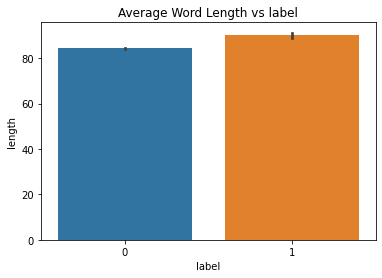

In [8]:
training_data['length'] = training_data['tweet'].apply(len)
fig1 = sns.barplot('label','length',data = training_data)
plt.title('Average Word Length vs label')
plot = fig1.get_figure()

Text(0.5, 1.0, 'Positive and Negative Label Counts')

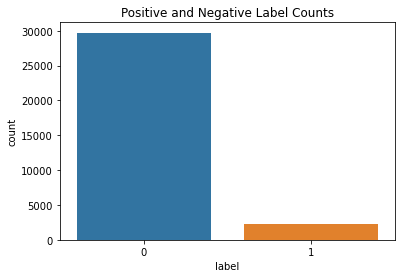

In [9]:
fig2 = sns.countplot(x= 'label',data = training_data)
plt.title('Positive and Negative Label Counts')

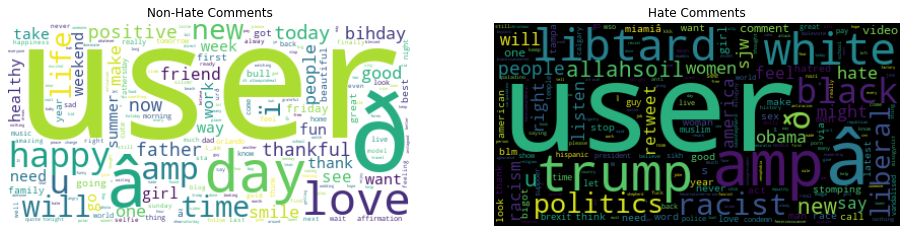

In [10]:
!pip install wordcloud
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(training_data['tweet'][training_data.label == 0])
text_neg = " ".join(training_data['tweet'][training_data.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

## Model Building

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

train_df, test_df =  train_test_split(training_data, test_size = 0.2, random_state = 42)

vectorizer = TfidfVectorizer()
train_tfidf_model = vectorizer.fit_transform(train_df.clean_tweet)
test_tfidf_model = vectorizer.transform(test_df.clean_tweet)
train_tfidf = pd.DataFrame(train_tfidf_model)

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from catboost import CatBoostClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

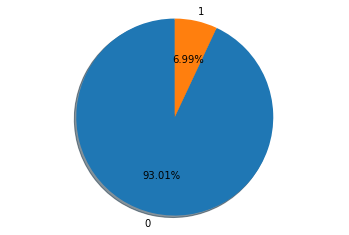

0    23783
1     1786
Name: label, dtype: int64


In [12]:
def createPieChartFor(t_df):
    Lst = 100*t_df.value_counts()/len(t_df)
    
    # set data for pie chart
    labels = t_df.value_counts().index.values
    sizes =  Lst 
    
    # set labels
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


# to account for data imbalance

createPieChartFor(train_df.label)

print(train_df.label.value_counts())

In [13]:
#Downsample

count_hate = train_df[train_df['label'] == 1]['clean_tweet'].count()
df_non_hate_speech = train_df[train_df['label'] == 0]
df_hate_speech = train_df[train_df['label'] == 1]
df_hate_speech_undersample = df_non_hate_speech.sample(count_hate, replace=True)
train_df_undersampled = pd.concat([df_hate_speech, df_hate_speech_undersample], axis=0)

print('Random under-sampling:')
print(train_df_undersampled['label'].value_counts())

Random under-sampling:
1    1786
0    1786
Name: label, dtype: int64


In [14]:
#Upsample

count_non_hate = train_df[train_df['label'] == 0]['clean_tweet'].count()
df_hate_speech = train_df[train_df['label'] == 1]
df_non_hate_speech = train_df[train_df['label'] == 0]
df_hate_speech_oversample = df_hate_speech.sample(count_non_hate, replace=True)
train_df_oversampled = pd.concat([df_non_hate_speech, df_hate_speech_oversample], axis=0)

print('Random over-sampling:')
print(train_df_oversampled['label'].value_counts())

Random over-sampling:
0    23783
1    23783
Name: label, dtype: int64


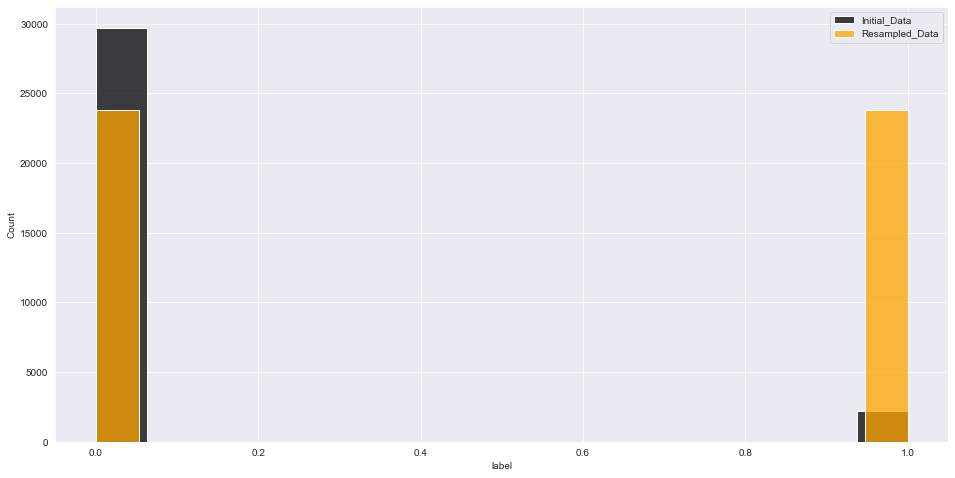

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
sns.histplot(data = training_data['label'], color='black', legend=True)
sns.histplot(data = train_df_oversampled['label'], color = 'orange', legend=True)
plt.legend(['Initial_Data', 'Resampled_Data'])
plt.show()

In [16]:
train_tfidf_model

<25569x33655 sparse matrix of type '<class 'numpy.float64'>'
	with 190455 stored elements in Compressed Sparse Row format>

In [17]:
train_tfidf = pd.DataFrame(train_tfidf_model)
train_tfidf

,0
0,"(0, 13794)\t0.33071680737776743\n (0, 33270..."
1,"(0, 13309)\t0.3149470806954164\n (0, 3183)\..."
2,"(0, 11991)\t0.3695368341242015\n (0, 17574)..."
3,"(0, 10606)\t0.5984368065298994\n (0, 30647)..."
4,"(0, 16117)\t0.3323714829149307\n (0, 20166)..."
...,...
25564,"(0, 31940)\t0.5230710332056848\n (0, 2697)\..."
25565,"(0, 15628)\t0.39594499466855876\n (0, 25167..."
25566,"(0, 2783)\t0.3254142701386868\n (0, 23869)\..."
25567,"(0, 15213)\t0.38537774704636485\n (0, 21196..."


In [18]:
cls = [LogisticRegression(),
       MultinomialNB(), 
       DecisionTreeClassifier(),
       RandomForestClassifier(n_estimators=200),
       KNeighborsClassifier(n_neighbors = 5),
      SGDClassifier(),
      LinearSVC(),
      AdaBoostClassifier(n_estimators=100),
      CatBoostClassifier(verbose=0)]

cls_name = []

In [19]:
test_tfidf_model

<6393x33655 sparse matrix of type '<class 'numpy.float64'>'
	with 42780 stored elements in Compressed Sparse Row format>

In [20]:
truelbl = test_df.label
i = 0
accuracy = []
for cl in cls:
    model = cl.fit(train_tfidf_model,train_df.label)
    lbl_pred = model.predict(test_tfidf_model)
    a = (100*accuracy_score(lbl_pred, truelbl))
    a = round(a,2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print ("{}  Accuracy Score : {}%".format(cls_name[i],a))
    print ( classification_report(lbl_pred, truelbl))
    i +=1

LogisticRegression  Accuracy Score : 94.82%
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6234
           1       0.31      0.89      0.46       159

    accuracy                           0.95      6393
   macro avg       0.65      0.92      0.72      6393
weighted avg       0.98      0.95      0.96      6393

MultinomialNB  Accuracy Score : 93.99%
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      6321
           1       0.16      1.00      0.27        72

    accuracy                           0.94      6393
   macro avg       0.58      0.97      0.62      6393
weighted avg       0.99      0.94      0.96      6393

DecisionTreeClassifier  Accuracy Score : 94.76%
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5942
           1       0.63      0.63      0.63       451

    accuracy                           0.95      63

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

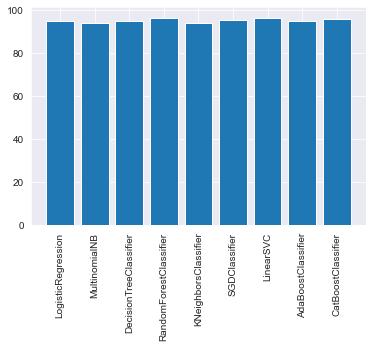

In [21]:
plt.bar(cls_name, accuracy)
plt.xticks(rotation=90)

In [22]:
##Using transformers

seq_len = 512
num_samples = len(training_data)

from transformers import BertTokenizer

# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# tokenize - this time returning Numpy tensors
tokens = tokenizer(training_data['tweet'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

In [23]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [24]:
with open('tweets-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('tweets-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [25]:
del tokens

In [26]:
arr = training_data['label'].values

labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(31962, 2)

In [27]:
labels[np.arange(num_samples), arr] = 1

labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [28]:
with open('tweets-labels.npy', 'wb') as f:
    np.save(f, labels)

In [29]:
with open('tweets-xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('tweets-xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('tweets-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [30]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [31]:
batch_size = 16

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 2), dtype=tf.float64, name=None))>

In [32]:
#creating a split for training and validation

split = 0.9

#calculate how many batches must be taken to create 90% training set
size = int((Xids.shape[0] / batch_size) * split)

size

1797

In [33]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

# free up memory
del dataset

In [34]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

In [35]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16, 2), dtype=tf.float64, name=None))

In [36]:
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

In [37]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [38]:
import tensorflow as tf

# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[0]  # access final activations with [0]

# convert bert embeddings into 5 output classes
x = tf.keras.layers.LSTM(32, dropout=.3, recurrent_dropout=.3, return_sequences=True)(embeddings)
x = tf.keras.layers.LSTM(16, dropout=.4, recurrent_dropout=.4, return_sequences=False)(x)
# normalize
x = tf.keras.layers.BatchNormalization()(x)
# output
x = tf.keras.layers.Dense(2, activation='relu')(x)
y = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(x)

In [39]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# print out model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [40]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

C:\Users\chadh\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [41]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.float64, name=None),
                 'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)},
                tf.TensorSpec(shape=(16, 2), dtype=tf.float64, name=None))

# load the training and validation sets
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

# view the input format
train_ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 2), dtype=tf.float64, name=None))>

In [42]:
#model.add(Dense(2, activation = 'softmax'))

In [43]:
#history = model.fit(
#    train_ds,
#    validation_data=val_ds,
#    epochs=2)

In [44]:
#model.save('sentiment_model')

INFO:tensorflow:Assets written to: sentiment_model\assets


INFO:tensorflow:Assets written to: sentiment_model\assets
